### Importing necessary packages

In [1]:
from dtaidistance import dtw
from functools import cmp_to_key
from sklearn.manifold import TSNE

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import re

### Defining important constants

In [2]:
DATA_FOLDER = '/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering ' \
              'I/Brain-Neuroactivity/data/'
GRAPHS_FOLDER = os.path.join(DATA_FOLDER, '08_graphs')
DATASET_FOLDER = os.path.join(DATA_FOLDER, '11_dataset')

MAIN_FEATURES = [
    'Lower_Body_To_Body_Distance_12',
    'Mean_Body_Position_Distance_12',
    'Nose_To_Nose_Distance_12',
    'Nose_To_Body_Distance_12',
    'Nose_To_Back_Distance_12',
    'Nose_To_Tail_End_Distance_12',
    'Lower_Body_To_Body_Is_Close',
    'Mean_Body_Position_Is_Close',
    'Nose_To_Nose_Is_Close',
    'Nose_To_Body_Is_Close',
    'Nose_To_Back_Is_Close',
    'Nose_To_Tail_End_Is_Close'
]

### Defining Video Name Sorting

In [3]:
def compare(a, b):
    if a > b:
        return 1
    elif a < b:
        return -1
    
    return None

def video_name_sort(a, b):
    regex = r'\d+'
    a_nums, b_nums = re.findall(regex, a['Video']), re.findall(regex, b['Video'])
    
    for i, j in zip(a_nums, b_nums):
        if int(i) > int(j):
            return 1
        if int(i) < int(j):
            return -1
        
    return 0

### Reading the dataset

In [4]:
file_path = os.path.join(DATASET_FOLDER, 'dataset.pickle')
video_idx_to_name = {}

with open(file_path, 'rb') as file:
    dataset = pickle.load(file)
    dataset = sorted(dataset, key=cmp_to_key(video_name_sort))
    
for i in range(len(dataset)):
    video_idx_to_name[i] = dataset[i]['Video']

In [5]:
video_idx_to_name

{0: 'Trial_1_v1_SI_w2_control_2593.mp4',
 1: 'Trial_1_v1_SI_w6_control_4037.mp4',
 2: 'Trial_1_v2_SI_w2_control_3839.mp4',
 3: 'Trial_1_v2_SI_w6_control_5302.mp4',
 4: 'Trial_1_v3_SI_w2_control_2168.mp4',
 5: 'Trial_1_v3_SI_w6_control_2168.mp4',
 6: 'Trial_2_v1_SI_w2_treatment_486.mp4',
 7: 'Trial_2_v1_SI_w6_control_10762.mp4',
 8: 'Trial_2_v2_SI_w2_control_5302.mp4',
 9: 'Trial_2_v2_SI_w6_control_3839.mp4',
 10: 'Trial_2_v3_SI_w2_treatment_333.mp4',
 11: 'Trial_2_v3_SI_w6_treatment_333.mp4',
 12: 'Trial_3_v1_SI_w2_control_10762.mp4',
 13: 'Trial_3_v1_SI_w6_treatment_486.mp4',
 14: 'Trial_3_v2_SI_w2_control_7162.mp4',
 15: 'Trial_3_v2_SI_w6_control_7162.mp4',
 16: 'Trial_3_v3_SI_w2_control_2686.mp4',
 17: 'Trial_3_v3_SI_w6_control_2686.mp4',
 18: 'Trial_4_v2_SI_w2_treatment_3829.mp4',
 19: 'Trial_4_v2_SI_w6_treatment_3829.mp4',
 20: 'Trial_4_SI_w2_treatment_1103.mp4',
 21: 'Trial_4_v3_SI_w2_treatment_5434.mp4',
 22: 'Trial_4_v3_SI_w6_treatment_5434.mp4',
 23: 'Trial_4_SI_w6_treatment_1

### Performing the HDBSCAN clustering

In [93]:
def build_HDBSCAN(dataset, feature, save_figure=False):
    X = np.zeros((len(dataset), len(dataset)))

    for i in range(len(dataset)-1):
        values1 = dataset[i]['Data'][feature].values[1:]
        
        if np.isnan(values1).any():
            values1 = pd.Series(values1).fillna(method='bfill').values

        for j in range(i+1, len(dataset)):
            values2 = dataset[j]['Data'][feature].values[1:]
            
            if np.isnan(values2).any():
                values2 = pd.Series(values2).fillna(method='bfill').values
            
            distance = dtw.distance_fast(values1, values2)
            X[i][j] = distance
            X[j][i] = distance
            
    clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2, n_jobs=-1)
    clusterer.fit(X)
    print(clusterer.labels_)
    
    fig, ax = plt.subplots(figsize=(30, 30), facecolor='white')
    
    X_embedded = TSNE(metric='precomputed').fit_transform(X)
    plt.scatter(*X_embedded.T)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('t-SNE Y', fontsize=30)
    ax.set_xlabel('t-SNE X', fontsize=30)
    
    plt.title(f"t-SNE Plot for {feature}", fontsize=40)
    plt.tight_layout()
    
    if save_figure:
        fig.savefig(f'{GRAPHS_FOLDER}/t-SNE_plot_for_{feature}.png', facecolor=fig.get_facecolor(), edgecolor='none')
        
    plt.show()

### Lower Body To Body Distance

[ 9 13  7  3 10  1 14  0 13  1  2 -1 16 16  9  1 14  3 13 10 17 -1 13 17
  8  7  9 17  1  1  2  2  0  8 17 10  5  8 11 -1  5  3  2  0  1  1  9 16
 17  3  1  1 -1 -1 14  0  3 -1 -1  8  2  9 -1 12  4 10 -1  6 10  6 11  3
  0  7  1  0  8 17  6 16  3  1 -1  0 -1  1  7 17 11 -1 17  7  1 -1  3 15
 10 12 -1 13  3 -1 10 10  1  6 15  8 10 15  1 12 13  4]


/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering I/Brain-Neuroactivity/venv/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


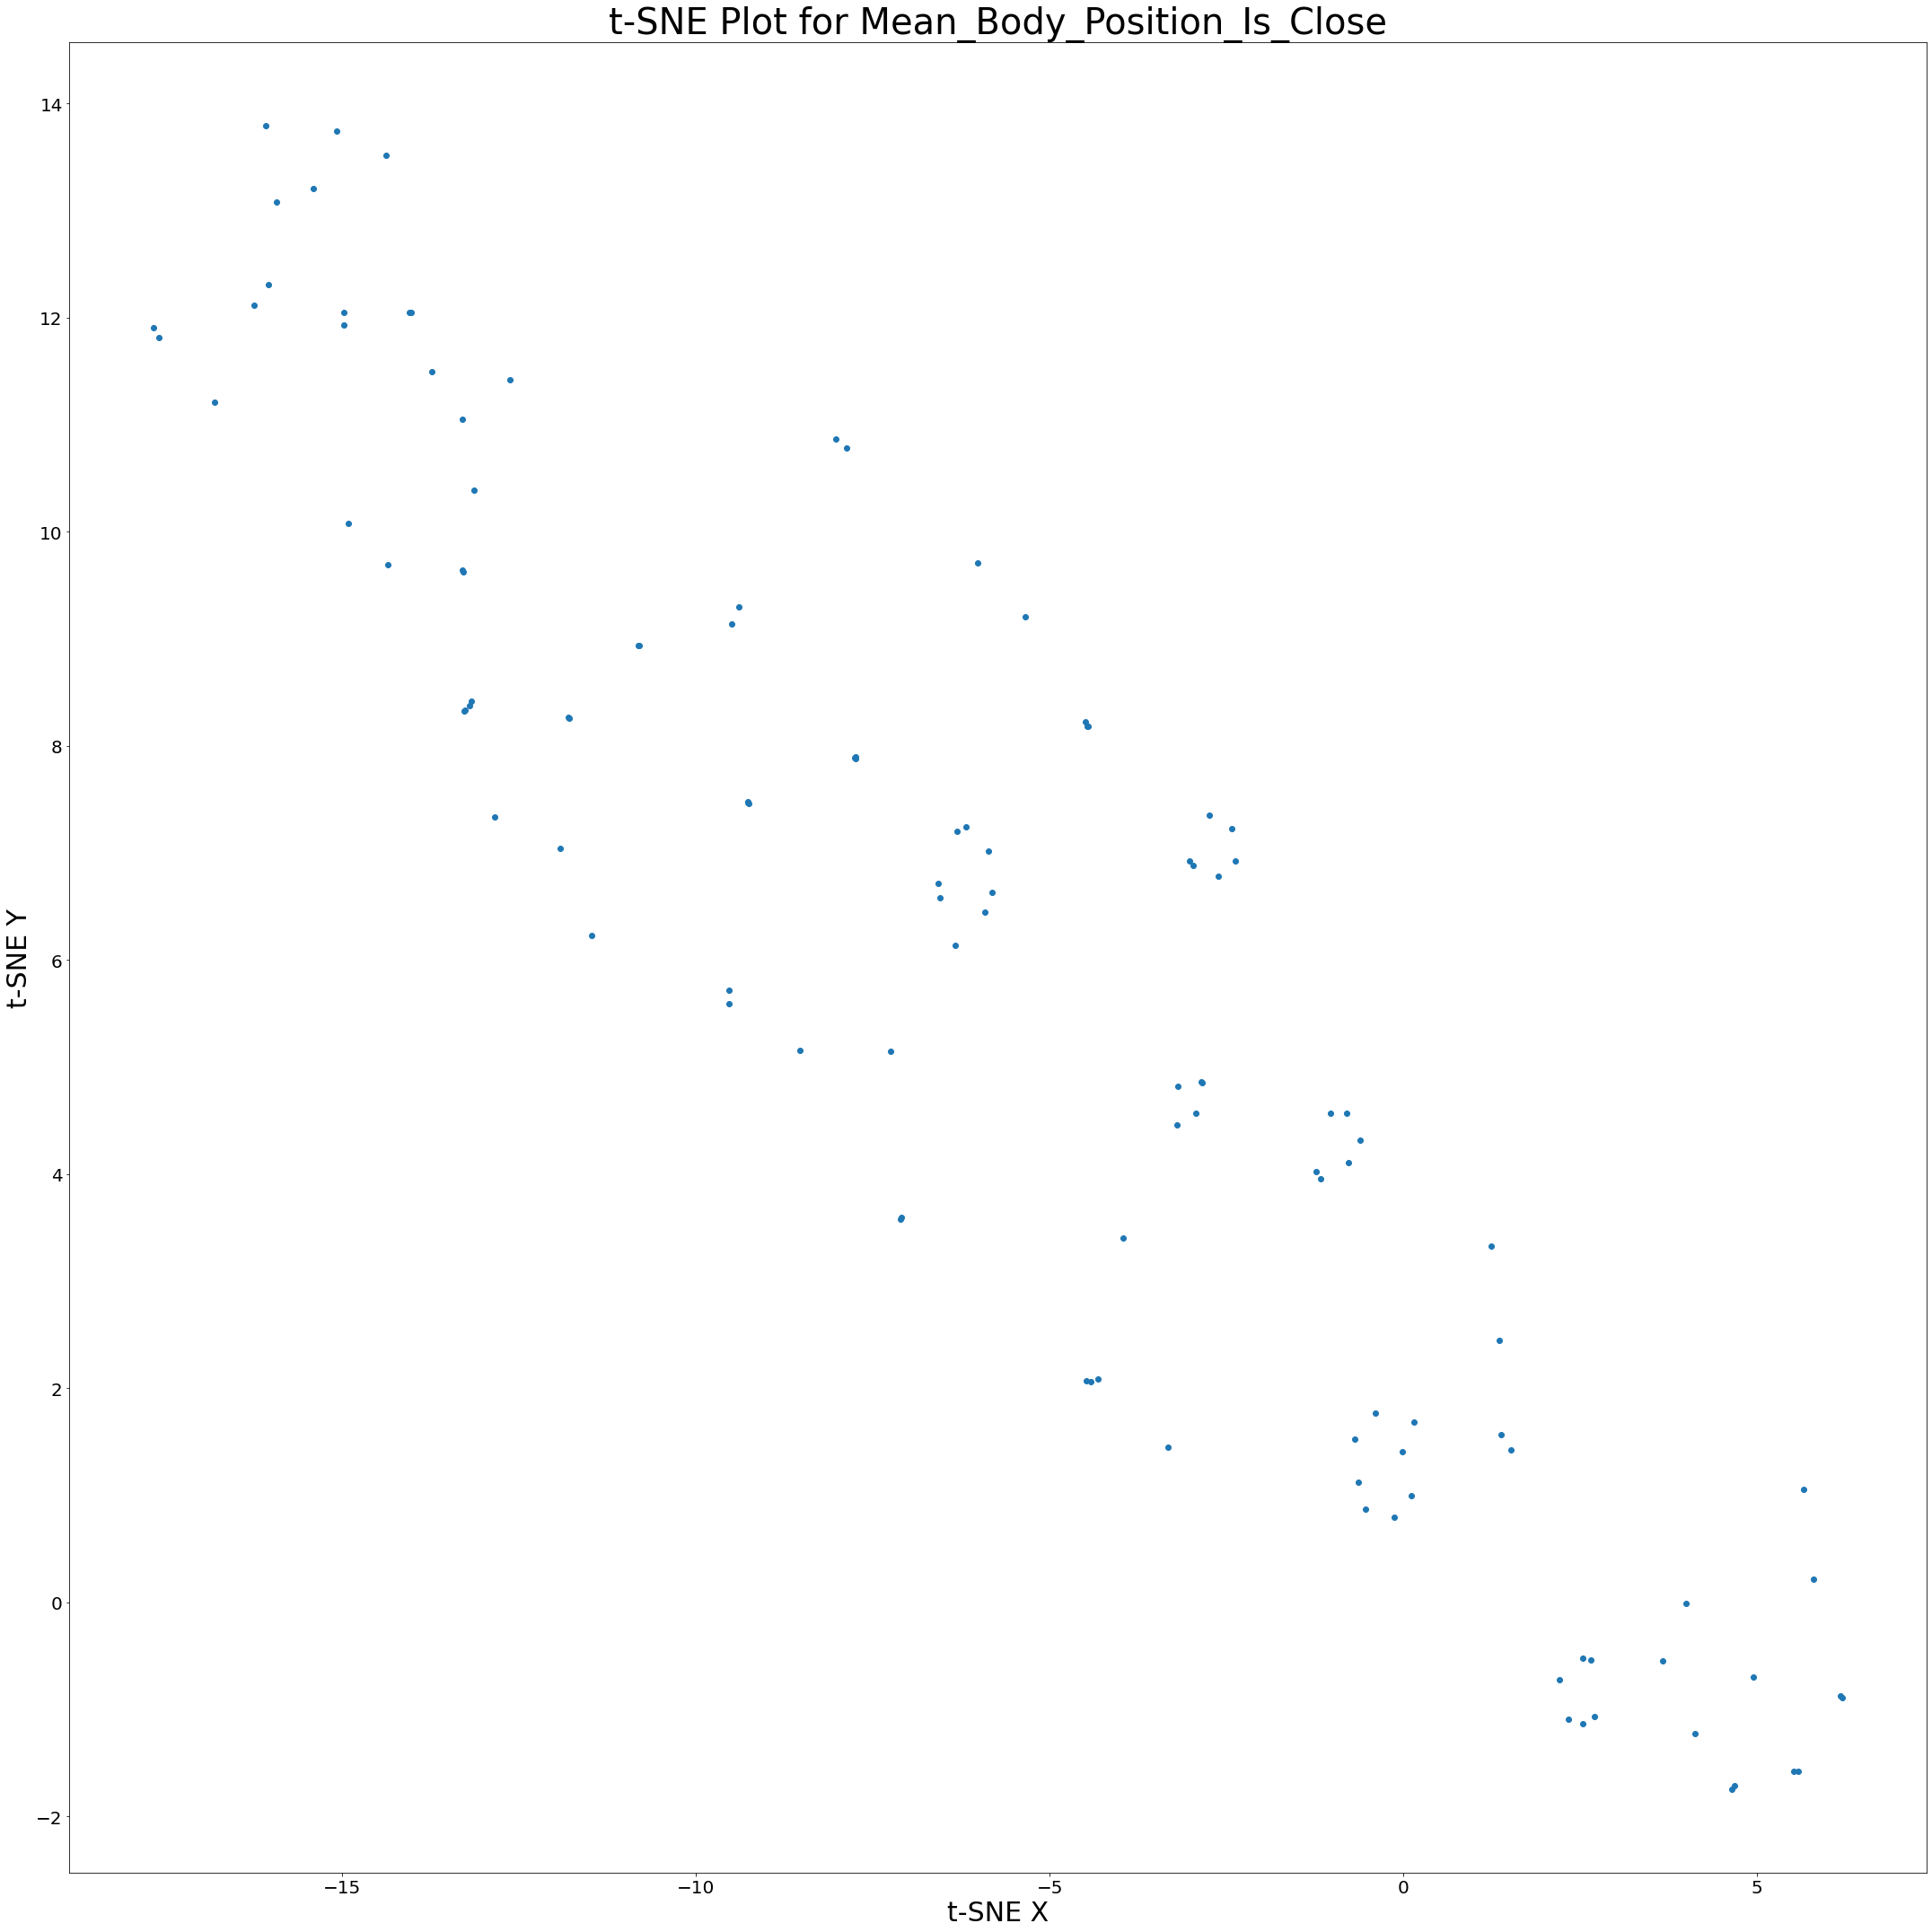

In [94]:
build_HDBSCAN(dataset, 'Mean_Body_Position_Is_Close', save_figure=True)

In [6]:
feature = 'Nose_To_Nose_Distance_12'

X = np.zeros((len(dataset), len(dataset)))

for i in range(len(dataset)-1):
    values1 = dataset[i]['Data'][feature].values[1:]

    if np.isnan(values1).any():
        values1 = pd.Series(values1).fillna(method='bfill').values
        
    values1 = values1.cumsum()

    for j in range(i+1, len(dataset)):
        values2 = dataset[j]['Data'][feature].values[1:]

        if np.isnan(values2).any():
            values2 = pd.Series(values2).fillna(method='bfill').values
            
        values2 = values2.cumsum()

        distance = dtw.distance_fast(values1, values2)
        X[i][j] = distance
        X[j][i] = distance

clusterer = hdbscan.HDBSCAN(metric='precomputed', n_jobs=-1)
clusterer.fit(X)
print(clusterer.labels_)

[ 5 -1  6  3 -1  2  5  4  5  5  6  2  5  2  2 -1  6 -1 -1  2  6  6  0  2
  2 -1  5  5 -1  3  6  6  2  6  1  1  2 -1  1 -1 -1  0 -1  0  6 -1  2  5
  2  6  5  3  2  6  2  2 -1  6  2  5 -1  0  5  6  6  6  4  6  6 -1  6  2
  3  1  3 -1  5 -1  4  0  2 -1  1  6 -1  6  6  2  0 -1  1  6  4  5  6  2
  2  2  2 -1  6 -1  5 -1  2  2  0  2  4 -1  4  3  1  6]


In [39]:
X_embedded = TSNE(metric='precomputed', n_jobs=-1).fit_transform(X)

/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering I/Brain-Neuroactivity/venv/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [40]:
len(clusterer.labels_)

114

In [62]:
print(X.mean())

1.896522808636219e+107


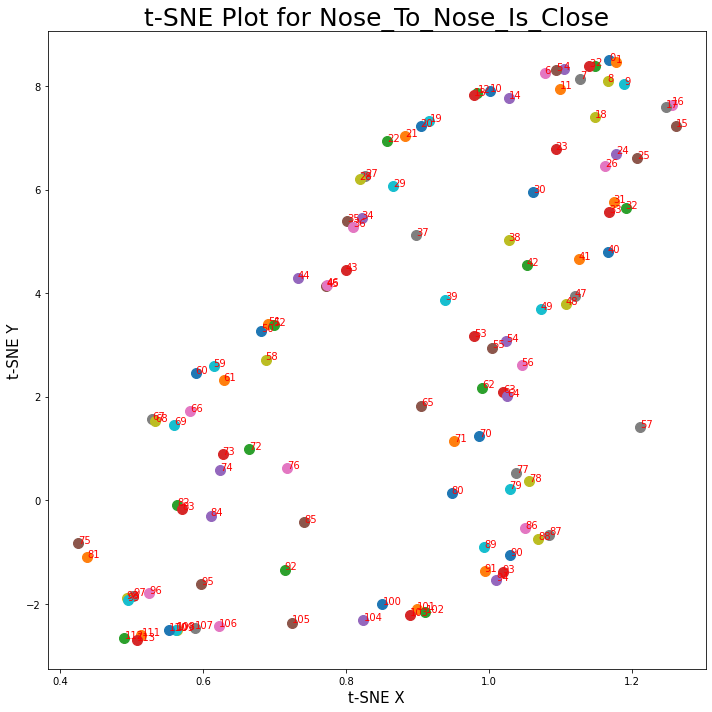

In [41]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

for i in range(len(clusterer.labels_)):
    plt.scatter(*X_embedded[i], s=100, label=clusterer.labels_[i])
    plt.text(*X_embedded[i], str(i), color="red", fontsize=10)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('t-SNE Y', fontsize=15)
ax.set_xlabel('t-SNE X', fontsize=15)

plt.title(f"t-SNE Plot for {feature}", fontsize=25)
plt.tight_layout()

# if save_figure:
#     fig.savefig(f'{GRAPHS_FOLDER}/t-SNE_plot_for_{feature}.png', facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()